In [1]:
import numpy as np
import random
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *
import networkx as nx
from utils import *
import time
import csv

In [2]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware
F_link = 1 # fidelity of local BP
mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)


In [3]:
def load_network(topology_file):
    g = nx.Graph()
    print('[*] Loading topology...', topology_file)
    f = open(topology_file, 'r')
    header = f.readline()
    real_nodes = []
    for line in f:
        line = line.strip()
        link = line.split('\t')
        Link_index,s,d,c,dist = link
        dist = float(dist)
        # if rv=="real":
        #     print(link)
        if int(s) not in real_nodes:
            real_nodes.append(int(s))
        if int(d) not in real_nodes:
            real_nodes.append(int(d))
        g.add_edge(int(s),int(d),weight=dist)
        g.add_edge(int(d),int(s),weight=dist)
    f.close()
    return g
def get_user_pairs(G,num_user_pairs,num_of_hups_away):
    list_of_nodes = []
    each_user_pair_path_links = {}
    covered_pairs = []
    user_pairs = []
    for node in G.nodes:
        list_of_nodes.append(node)
    res = [(a, b) for idx, a in enumerate(list_of_nodes) for b in list_of_nodes[idx + 1:]]
    for pair in res:
        node1 = pair[0]
        node2 = pair[1]
        e = (node1,node2)
        reverse_e = (node2,node1)
        if (node1!=node2 and e not in G.edges and reverse_e not in G.edges and
            (node1,node2) not in covered_pairs and (node2,node1) not in covered_pairs):
            try:
                dist =nx.shortest_path_length(G, source=node1, target=node2, weight="weight")
                path = nx.shortest_path(G, source=node1, target=node2, weight="weight")
                
            except ValueError:
                print(ValueError)
                dist=-1
            if dist>100 and dist <=200 and len(path)>=num_of_hups_away and len(user_pairs)<num_user_pairs:
                node_indx = 0
                path_edges = []
                for node_indx in range(len(path)-1):
                    path_edges.append((path[node_indx],path[node_indx+1]))
                    node_indx+=1
                links = []
                for edge in path_edges:
                    dist =nx.shortest_path_length(G, source=edge[0], target=edge[1], weight="weight")
                    links.append(dist)
                each_user_pair_path_links[(node1,node2)] = links
                user_pairs.append((node1,node2))
                covered_pairs.append((node1,node2))
                covered_pairs.append((node2,node1))
    return user_pairs,each_user_pair_path_links

def get_optimal_skr(num_τ,user_pair_list):
    τ_coh_list = np.logspace(-2,-1,10) # coherence time [sec]
    raw_rate_seq = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    skr_seq = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    Fe2e_seq = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    skr_seq_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    raw_rate_seq_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    Fe2e_seq_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    τ_cut_opt_seq =  np.zeros((len(user_pair_list),len(τ_coh_list)))
    skr_seq_no_cut =  np.zeros((len(user_pair_list),len(τ_coh_list)))
    raw_rate_seq_no_cut = np.zeros((len(user_pair_list),len(τ_coh_list)))

    
    raw_rate_par = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    skr_par = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    Fe2e_par = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    skr_par_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    raw_rate_par_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    Fe2e_par_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    τ_cut_opt_par =  np.zeros((len(user_pair_list),len(τ_coh_list)))
    skr_par_no_cut =  np.zeros((len(user_pair_list),len(τ_coh_list)))
    raw_rate_par_no_cut =  np.zeros((len(user_pair_list),len(τ_coh_list)))
    
    for i_user,user_pair in enumerate(user_pair_list):
        
        Ls = each_user_pair_path_links[(user_pair[0],user_pair[1])]
        Ls = np.array(Ls)
        Le2e = sum(Ls)
        # print(user_pair,len(Ls),Ls,Le2e,end='\r')
        # τ_cut_list = np.logspace(-0.5,2,num_τ)*Ls[0]/c/2 # cutoff [sec]
        τ_cut_list = np.logspace(-1,2,num_τ)*Le2e/c/2 # cutoff [sec]
        # print(raw_rate_seq, skr_seq, Fe2e_seq)
        for i_coh, τ_coh in enumerate(τ_coh_list):
            start_time = time.time()
            for i_t, τ_cut in enumerate(τ_cut_list):
                #print("for i_user %s for i_coh %s for i_t %s "%(i_user,i_coh,i_t))
                raw_rate_seq[i_user,i_coh,i_t], skr_seq[i_user,i_coh,i_t], Fe2e_seq[i_user,i_coh,i_t] = T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
                # raw_rate_par[i_user,i_coh,i_t], skr_par[i_user,i_coh,i_t], Fe2e_par[i_user,i_coh,i_t] = T_parallel_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
                if isnan(skr_seq[i_user,i_coh,i_t]):
                    skr_seq[i_user,i_coh,i_t] = 1e-20
                if isnan(skr_par[i_user,i_coh,i_t]):
                    skr_par[i_user,i_coh,i_t] = 1e-20
            idx_seq = np.argmax(skr_seq[i_user,i_coh,:])
            idx_par = np.argmax(skr_par[i_user,i_coh,:])
    
            skr_seq_opt[i_user,i_coh] = skr_seq[i_user,i_coh,idx_seq]
            raw_rate_seq_opt[i_user,i_coh] = raw_rate_seq[i_user,i_coh,idx_seq]
            Fe2e_seq_opt[i_user,i_coh] = Fe2e_seq[i_user,i_coh,idx_seq]
            τ_cut_opt_seq[i_user,i_coh] = τ_cut_list[idx_seq]
            skr_par_opt[i_user,i_coh] = skr_par[i_user,i_coh,idx_par]
            raw_rate_par_opt[i_user,i_coh] = raw_rate_par[i_user,i_coh,idx_par]
            Fe2e_par_opt[i_user,i_coh] = Fe2e_par[i_user,i_coh,idx_par]
            τ_cut_opt_par[i_user,i_coh] = τ_cut_list[idx_par]
                
            raw_rate_seq_no_cut[i_user,i_coh], skr_seq_no_cut[i_user,i_coh], _ = T_sequential_no_cutoff(τ_coh, mu_link, F_link, Ls)
            raw_rate_par_no_cut[i_user,i_coh], skr_par_no_cut[i_user,i_coh], _ = T_parallel_no_cutoff(τ_coh, mu_link, F_link, Ls)
            ending_time = time.time()
            print("took %s done for user pair %s from %s %s from %s coherence values "%(ending_time-start_time,i_user,len(user_pair_list),i_coh,len(τ_coh_list)))
        
    return raw_rate_seq_opt,skr_seq_opt,raw_rate_par_opt,skr_par_opt,raw_rate_seq_no_cut,skr_seq_no_cut,raw_rate_par_no_cut,skr_par_no_cut,τ_coh_list
def get_skr_no_cutoff(protocol_key,user_pair,coh_time):
    return 0

In [4]:
num_τ = 200
num_user_pairs = 100
num_of_hups_away = 4
graph = load_network("Surfnet.txt")
user_pair_list,each_user_pair_path_links = get_user_pairs(graph,num_user_pairs,num_of_hups_away)
print(len(user_pair_list))
user_pair_list = np.array(user_pair_list)
raw_rate_seq_opt,skr_seq_opt,raw_rate_par_opt,skr_par_opt,raw_rate_seq_no_cut,skr_seq_no_cut,raw_rate_par_no_cut,skr_par_no_cut,τ_coh_list= get_optimal_skr(num_τ,user_pair_list)



[*] Loading topology... Surfnet.txt
100
took 0.025820493698120117 done for user pair 0 from 100 0 from 10 coherence values 
took 0.024576425552368164 done for user pair 0 from 100 1 from 10 coherence values 
took 0.02454352378845215 done for user pair 0 from 100 2 from 10 coherence values 
took 0.024562358856201172 done for user pair 0 from 100 3 from 10 coherence values 
took 0.024600982666015625 done for user pair 0 from 100 4 from 10 coherence values 


/home/shahrooz/repeater_chains/figures_paper/utils.py:228: RuntimeWarning: divide by zero encountered in scalar divide
  T_tot = T_tot / Pm +  (1/Pm -1)*τ_cut + Nm(p_n)*2*τs[i_l]/Pm
/home/shahrooz/repeater_chains/figures_paper/utils.py:228: RuntimeWarning: invalid value encountered in scalar divide
  T_tot = T_tot / Pm +  (1/Pm -1)*τ_cut + Nm(p_n)*2*τs[i_l]/Pm
/home/shahrooz/repeater_chains/figures_paper/utils.py:236: RuntimeWarning: divide by zero encountered in divide
  f_memory_qkd = np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-2*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
/home/shahrooz/repeater_chains/figures_paper/utils.py:236: RuntimeWarning: invalid value encountered in multiply
  f_memory_qkd = np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-2*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_

took 0.02461385726928711 done for user pair 0 from 100 5 from 10 coherence values 
took 0.024708986282348633 done for user pair 0 from 100 6 from 10 coherence values 
took 0.02442026138305664 done for user pair 0 from 100 7 from 10 coherence values 
took 0.025845050811767578 done for user pair 0 from 100 8 from 10 coherence values 
took 0.02511906623840332 done for user pair 0 from 100 9 from 10 coherence values 
took 0.02399921417236328 done for user pair 1 from 100 0 from 10 coherence values 
took 0.023625612258911133 done for user pair 1 from 100 1 from 10 coherence values 
took 0.02371668815612793 done for user pair 1 from 100 2 from 10 coherence values 
took 0.0237576961517334 done for user pair 1 from 100 3 from 10 coherence values 
took 0.02369856834411621 done for user pair 1 from 100 4 from 10 coherence values 
took 0.02404308319091797 done for user pair 1 from 100 5 from 10 coherence values 
took 0.023534297943115234 done for user pair 1 from 100 6 from 10 coherence values 
t

In [ ]:
results_file_path = "SURFnet_each_user_coh_protocol_skrv2.csv"
# row = Par_ebit,Par_SKR,Seq_ebit,seq_SKR,Par_no_ct_ebit,Par_no_ct_SKR,Seq_no_ct_ebit,Seq_no_ct_SKR
for i_user,user_pair in enumerate(user_pair_list):
    for i_coh, τ_coh in enumerate(τ_coh_list):
        Par_ebit,Par_SKR = raw_rate_par_opt[i_user,i_coh],skr_par_opt[i_user,i_coh]
        Seq_ebit,seq_SKR = raw_rate_seq_opt[i_user,i_coh],skr_seq_opt[i_user,i_coh]
        Par_no_ct_ebit,Par_no_ct_SKR= raw_rate_par_no_cut[i_user,i_coh],skr_par_no_cut[i_user,i_coh]
        Seq_no_ct_ebit,Seq_no_ct_SKR = raw_rate_seq_no_cut[i_user,i_coh],skr_seq_no_cut[i_user,i_coh]
        with open(results_file_path, 'a') as newFile:                                
            newFileWriter = csv.writer(newFile)
            newFileWriter.writerow([i_user,user_pair[0],user_pair[1],i_coh, τ_coh,
                                    Par_ebit,Par_SKR,
                                    Seq_ebit,seq_SKR,
                                    Par_no_ct_ebit,Par_no_ct_SKR,
                                    Seq_no_ct_ebit,Seq_no_ct_SKR])

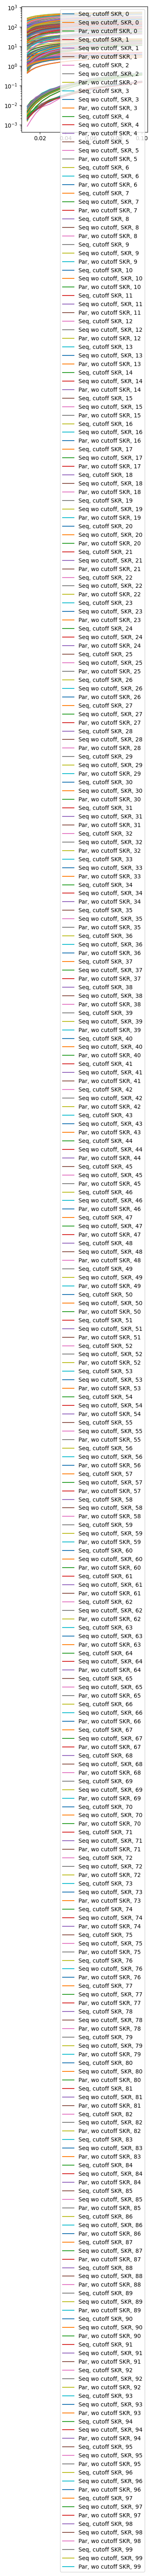

In [5]:
# import pdb
# pdb.set_trace()
color_indx = -1
plt.figure(figsize=(4,4))
for i_user, user_pair in enumerate(user_pair_list):
    color_indx+=1
    plt.plot(τ_coh_list,skr_seq_opt[i_user,:],"-",color=f"C{color_indx}",label="Seq, cutoff SKR, "+str(i_user))
    color_indx+=1
    plt.plot(τ_coh_list,skr_seq_no_cut[i_user,:],"-",color=f"C{color_indx}",label="Seq wo cutoff, SKR, "+str(i_user))
    color_indx+=1
    plt.plot(τ_coh_list,skr_par_no_cut[i_user,:],"-",color=f"C{color_indx}",label="Par, wo cutoff SKR, "+str(i_user))
plt.yscale('log')
plt.legend()

Text(0, 0.5, 'Rate')

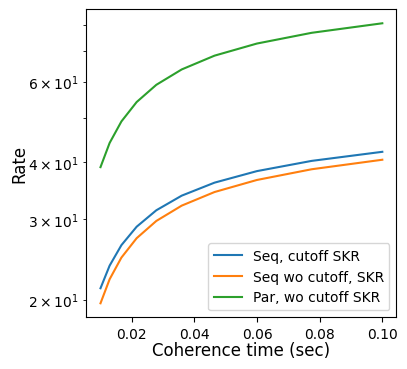

In [10]:
skr_seq_opt_values=[]
skr_seq_no_cut_values=[]
skr_par_no_cut_values=[]
skr_seq_opt_avg=[]
skr_seq_no_cut_avg=[]
skr_par_no_cut_avg=[]
for i_coh,coh_t in enumerate(τ_coh_list):
    for i_user, user_pair in enumerate(user_pair_list):
        skr_seq_opt_values.append(skr_seq_opt[i_user,i_coh])
        skr_seq_no_cut_values.append(skr_seq_no_cut[i_user,i_coh])
        skr_par_no_cut_values.append(skr_par_no_cut[i_user,i_coh])
    skr_seq_opt_avg.append(sum(skr_seq_opt_values)/len(skr_seq_opt_values))
    skr_seq_no_cut_avg.append(sum(skr_seq_no_cut_values)/len(skr_seq_no_cut_values))
    skr_par_no_cut_avg.append(sum(skr_par_no_cut_values)/len(skr_par_no_cut_values))
color_indx = -1
plt.figure(figsize=(4,4))
color_indx+=1
plt.plot(τ_coh_list,skr_seq_opt_avg,"-",color=f"C{color_indx}",label="Seq, cutoff SKR")
color_indx+=1
plt.plot(τ_coh_list,skr_seq_no_cut_avg,"-",color=f"C{color_indx}",label="Seq wo cutoff, SKR")
color_indx+=1
plt.plot(τ_coh_list,skr_par_no_cut_avg,"-",color=f"C{color_indx}",label="Par, wo cutoff SKR")
plt.yscale('log')
plt.legend()
plt.xlabel("Coherence time (sec)", fontsize=12,labelpad=0)
#matplotlib.rcParams['text.usetex'] = True
plt.ylabel("Rate",fontsize=12,labelpad=0)